# Agent Supervisor

The [previous example](./multi-agent-collaboration.ipynb) routed messages
automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate
tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class
from LangChain. This and other "advanced agent" notebooks are designed to show
how you can implement certain design patterns in LangGraph. If the pattern suits
your needs, we recommend combining it with some of the other fundamental
patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [2]:
// process.env.OPENAI_API_KEY = "sk_...";
// process.env.TAVILY_API_KEY = "sk_...";
// Optional tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "sk_...";
// process.env.LANGCHAIN_TRACING_V2 = "true";
// process.env.LANGCHAIN_PROJECT = "Agent Supervisor: LangGraphJS";

In [3]:
import "dotenv/config";

### Define State

We first define the state of the graph. This will just a list of messages, along
with a key to track the most recent sender


In [4]:
import { END, Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

// This defines the object that is passed between each node
// in the graph. We will create different nodes for each agent and tool
const AgentState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
    default: () => [],
  }),
  // The agent node that last performed work
  next: Annotation<string>({
    reducer: (x, y) => y ?? x ?? END,
    default: () => END,
  }),
});

## Create tools

For this example, you will make an agent to do web research with a search
engine, and one agent to create plots. Define the tools they'll use below:

In [5]:
require("esm-hook"); // Only for running this in TSLab. See: https://github.com/yunabe/tslab/issues/72
import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { DynamicStructuredTool } from "@langchain/core/tools";
import * as d3 from "d3";
// ----------ATTENTION----------
// If attempting to run this notebook locally, you must follow these instructions
// to install the necessary system dependencies for the `canvas` package.
// https://www.npmjs.com/package/canvas#compiling
// -----------------------------
import { createCanvas } from "canvas";
import { z } from "zod";
import * as tslab from "tslab";

const chartTool = new DynamicStructuredTool({
  name: "generate_bar_chart",
  description:
    "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
  schema: z.object({
    data: z
      .object({
        label: z.string(),
        value: z.number(),
      })
      .array(),
  }),
  func: async ({ data }) => {
    const width = 500;
    const height = 500;
    const margin = { top: 20, right: 30, bottom: 30, left: 40 };

    const canvas = createCanvas(width, height);
    const ctx = canvas.getContext("2d");

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1);

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value) ?? 0])
      .nice()
      .range([height - margin.bottom, margin.top]);

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ];

    data.forEach((d, idx) => {
      ctx.fillStyle = colorPalette[idx % colorPalette.length];
      ctx.fillRect(
        x(d.label) ?? 0,
        y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value),
      );
    });

    ctx.beginPath();
    ctx.strokeStyle = "black";
    ctx.moveTo(margin.left, height - margin.bottom);
    ctx.lineTo(width - margin.right, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "center";
    ctx.textBaseline = "top";
    x.domain().forEach((d) => {
      const xCoord = (x(d) ?? 0) + x.bandwidth() / 2;
      ctx.fillText(d, xCoord, height - margin.bottom + 6);
    });

    ctx.beginPath();
    ctx.moveTo(margin.left, height - margin.top);
    ctx.lineTo(margin.left, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "right";
    ctx.textBaseline = "middle";
    const ticks = y.ticks();
    ticks.forEach((d) => {
      const yCoord = y(d); // height - margin.bottom - y(d);
      ctx.moveTo(margin.left, yCoord);
      ctx.lineTo(margin.left - 6, yCoord);
      ctx.stroke();
      ctx.fillText(d.toString(), margin.left - 8, yCoord);
    });
    await tslab.display.png(canvas.toBuffer());
    return "Chart has been generated and displayed to the user!";
  },
});

const tavilyTool = new TavilySearchResults();

## Create Agent Supervisor

The supervisor routes the work between our worker agents.

In [6]:
import { z } from "zod";
import { JsonOutputToolsParser } from "langchain/output_parsers";
import { ChatOpenAI } from "@langchain/openai";
import { ChatPromptTemplate, MessagesPlaceholder } from "@langchain/core/prompts";

const members = ["researcher", "chart_generator"] as const;

const systemPrompt =
  "You are a supervisor tasked with managing a conversation between the" +
  " following workers: {members}. Given the following user request," +
  " respond with the worker to act next. Each worker will perform a" +
  " task and respond with their results and status. When finished," +
  " respond with FINISH.";
const options = [END, ...members];

// Define the routing function
const routingTool = {
  name: "route",
  description: "Select the next role.",
  schema: z.object({
    next: z.enum([END, ...members]),
  }),
}

const prompt = ChatPromptTemplate.fromMessages([
  ["system", systemPrompt],
  new MessagesPlaceholder("messages"),
  [
    "system",
    "Given the conversation above, who should act next?" +
    " Or should we FINISH? Select one of: {options}",
  ],
]);

const formattedPrompt = await prompt.partial({
  options: options.join(", "),
  members: members.join(", "),
});

const llm = new ChatOpenAI({
  modelName: "gpt-4o",
  temperature: 0,
});

const supervisorChain = formattedPrompt
  .pipe(llm.bindTools(
    [routingTool],
    {
      tool_choice: "route",
    },
  ))
  .pipe(new JsonOutputToolsParser())
  // select the first one
  .pipe((x) => (x[0].args));

In [7]:
import { HumanMessage } from "@langchain/core/messages";

await supervisorChain.invoke({
  messages: [
    new HumanMessage({
      content: "write a report on birds.",
    }),
  ],
});

{ next: 'researcher' }


## Construct Graph

We're ready to start building the graph. First, create the agents to add to the
graph.

<div class="admonition tip">
    <p class="admonition-title">Compatibility</p>
    <p>
        The <a href="https://langchain-ai.github.io/langgraphjs/reference/types/langgraph_prebuilt.CreateReactAgentParams.html"><code>stateModifier</code></a> parameter was added in <code>@langchain/langgraph>=0.2.27</code>.
        <br />
        If you are on an older version, you will need to use the deprecated <code>messageModifier</code> parameter.
        <br />
        For help upgrading, see <a href="/langgraphjs/how-tos/manage-ecosystem-dependencies/">this guide</a>.
    </p>
</div>


In [8]:
import { RunnableConfig } from "@langchain/core/runnables";
import { createReactAgent } from "@langchain/langgraph/prebuilt";
import { SystemMessage } from "@langchain/core/messages";

// Recall llm was defined as ChatOpenAI above
// It could be any other language model
const researcherAgent = createReactAgent({
  llm,
  tools: [tavilyTool],
  stateModifier: new SystemMessage("You are a web researcher. You may use the Tavily search engine to search the web for" +
    " important information, so the Chart Generator in your team can make useful plots.")
})

const researcherNode = async (
  state: typeof AgentState.State,
  config?: RunnableConfig,
) => {
  const result = await researcherAgent.invoke(state, config);
  const lastMessage = result.messages[result.messages.length - 1];
  return {
    messages: [
      new HumanMessage({ content: lastMessage.content, name: "Researcher" }),
    ],
  };
};

const chartGenAgent = createReactAgent({
  llm,
  tools: [chartTool],
  stateModifier: new SystemMessage("You excel at generating bar charts. Use the researcher's information to generate the charts.")
})

const chartGenNode = async (
  state: typeof AgentState.State,
  config?: RunnableConfig,
) => {
  const result = await chartGenAgent.invoke(state, config);
  const lastMessage = result.messages[result.messages.length - 1];
  return {
    messages: [
      new HumanMessage({ content: lastMessage.content, name: "ChartGenerator" }),
    ],
  };
};

Now we can create the graph itself! Add the nodes, and add edges to define how
how work will be performed in the graph.

In [9]:
import { START, StateGraph } from "@langchain/langgraph";

// 1. Create the graph
const workflow = new StateGraph(AgentState)
  // 2. Add the nodes; these will do the work
  .addNode("researcher", researcherNode)
  .addNode("chart_generator", chartGenNode)
  .addNode("supervisor", supervisorChain);
// 3. Define the edges. We will define both regular and conditional ones
// After a worker completes, report to supervisor
members.forEach((member) => {
  workflow.addEdge(member, "supervisor");
});

workflow.addConditionalEdges(
  "supervisor",
  (x: typeof AgentState.State) => x.next,
);

workflow.addEdge(START, "supervisor");

const graph = workflow.compile();

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

{ supervisor: { next: 'researcher' } }
----
{
  researcher: {
    messages: [
      HumanMessage {
        "content": "Based on the search results, the three most popular TV shows in 2023 were:\n\n1. **Succession** - This show has been highly acclaimed and frequently mentioned in various lists of top TV shows for 2023.\n2. **The Last of Us** - An adaptation of the popular video game, this show has received significant attention and praise.\n3. **The Bear** - This series has also been highlighted as one of the best and most popular shows of the year.\n\nThese shows have been consistently mentioned across different sources, including Rotten Tomatoes, Metacritic, and IMDb.",
        "name": "Researcher",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
----
{ supervisor: { next: 'chart_generator' } }
----


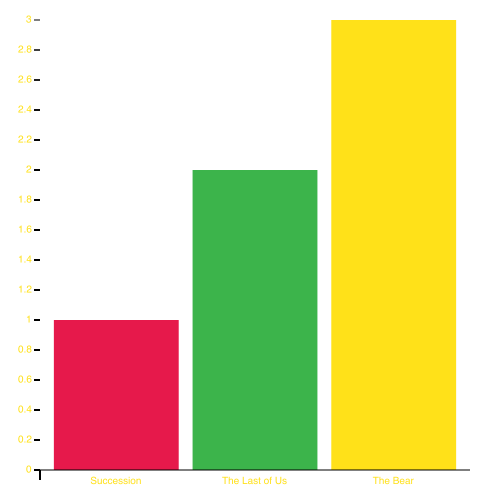

{
  chart_generator: {
    messages: [
      HumanMessage {
        "content": "Here is a bar chart representing the three most popular TV shows in 2023:\n\n1. **Succession**\n2. **The Last of Us**\n3. **The Bear**\n\n![Bar Chart](sandbox:/generated_chart.png)",
        "name": "ChartGenerator",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
----
{ supervisor: { next: '__end__' } }
----


In [10]:
let streamResults = graph.stream(
  {
    messages: [
      new HumanMessage({
        content: "What were the 3 most popular tv shows in 2023?",
      }),
    ],
  },
  { recursionLimit: 100 },
);

for await (const output of await streamResults) {
  if (!output?.__end__) {
    console.log(output);
    console.log("----");
  }
}

{ supervisor: { next: 'researcher' } }
----
{
  researcher: {
    messages: [
      HumanMessage {
        "content": "Based on the search results, here are the US GDP growth rates for the years 2021 to 2023:\n\n- **2021**: 5.9%\n- **2022**: 2.1%\n- **2023**: 3.3% (advance estimate for the fourth quarter)\n\nThis data can be used to generate a bar chart. I'll pass this information to the Chart Generator in the team.",
        "name": "Researcher",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
----
{ supervisor: { next: 'chart_generator' } }
----


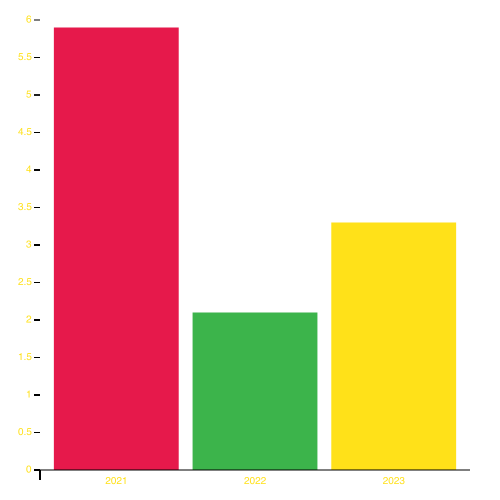

{
  chart_generator: {
    messages: [
      HumanMessage {
        "content": "Here is the bar chart showing the US GDP growth from 2021 to 2023:\n\n![US GDP Growth 2021-2023](sandbox:/generated_chart.png)\n\n- **2021**: 5.9%\n- **2022**: 2.1%\n- **2023**: 3.3% (advance estimate)\n\nIf you need any further analysis or additional charts, feel free to ask!",
        "name": "ChartGenerator",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
----
{ supervisor: { next: '__end__' } }
----


In [11]:
streamResults = graph.stream(
  {
    messages: [
      new HumanMessage({
        content: "Generate a bar chart of the US GDP growth from 2021-2023.",
      }),
    ],
  },
  { recursionLimit: 150 },
);

for await (const output of await streamResults) {
  if (!output?.__end__) {
    console.log(output);
    console.log("----");
  }
}

You can
[click here](https://smith.langchain.com/public/5eaaaaa9-c490-487d-b7f1-984aeea87c0f/r)
to see a LangSmith trace of the above query.